# Decision tree classification

First, we're starting off with a simple decision tree. Using only numerical values, we split the data on the cleanest seperation of class labels according to the gini index.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('Data/preprocessedTrain.csv') #import data
X = data.loc[:, data.columns != 'AdoptionSpeed'] #create X without labels
X = X.drop('Description',axis=1) #drop non numerical values
X = X.drop('PetID',axis=1) #
X = X.drop('RescuerID',axis=1)

y = data['AdoptionSpeed'] #label vector

attributeNames = list(X.columns.values) #for printing purposes
classNames = ['sameDay','firstWeek','firstMonth','2nd3rdMonth','notAdopted']

In [32]:
from sklearn import tree
from Toolbox import treeprint
from sklearn import model_selection
import matplotlib.pyplot as plt

test_proportion = 0.5  # set crossval proportion
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=test_proportion)
levels = range(2,51)
error = np.zeros((2,len(levels)))

for t in levels:
    dtc = tree.DecisionTreeClassifier(criterion='gini', max_depth=t) #train decision tree
    dtc = dtc.fit(X_train,y_train)
    
    y_est_test = dtc.predict(X_test)
    y_est_train = dtc.predict(X_train)
    
    test_class_error = 1-np.mean(y_est_test == y_test)
    train_class_error = 1-np.mean(y_est_train == y_train)
    error[0,t-2], error[1,t-2]= train_class_error, test_class_error


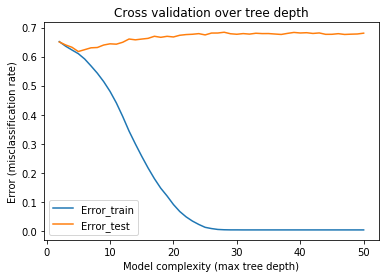

Lowest average error is 0.3397 at 35 using 50.0 percent for testing
Lowest unweighted error is 0.3397 at 35
Lowest test error is 0.6174 at 3


In [66]:
plt.plot(levels, error[0,:])
plt.plot(levels, error[1,:])
plt.xlabel('Model complexity (max tree depth)')
plt.ylabel('Error (misclassification rate)')
plt.legend(['Error_train','Error_test']) 
plt.title('Cross validation over tree depth')
plt.show()  
errorSum = test_proportion*error[1,:] + (1-test_proportion)*error[0,:] # mean error
error_equal = sum(error)
print('Lowest average error is {:.4f} at {} using {} percent for testing'.format(min(errorSum), np.argmin(errorSum),test_proportion*100))
print('Lowest unweighted error is {:.4f} at {}'.format(min(error_equal)/2,np.argmin(error_equal)))
print('Lowest test error is {:.4f} at {}'.format(min(error[1,:]),np.argmin(error[1,:])))

dtc = tree.DecisionTreeClassifier(criterion='gini', max_depth=np.argmin(errorSum)) #find relevant attributes
dtc = dtc.fit(X,y)

attribute_importance = [(attributeNames[i],dtc.feature_importances_[i]) for i in range(len(attributeNames))]
attributes_sorted = sorted(attribute_importance, key=lambda item: item[1], reverse=True)

In [69]:
print('Features in order of importance:')
print(*['{}: {:.4f}'.format(i[0],i[1]) for i in attributes_sorted],sep='\n')

Features in order of importance:
PhotoAmt: 0.0954
Age: 0.0911
Breed1: 0.0676
Color2: 0.0643
Color1: 0.0567
State: 0.0483
Breed2: 0.0413
FurLength: 0.0336
Color3: 0.0330
Gender: 0.0323
Quantity: 0.0297
adopt: 0.0295
MaturitySize: 0.0294
Vaccinated: 0.0287
Dewormed: 0.0281
Fee: 0.0260
Sterilized: 0.0248
love: 0.0241
play: 0.0214
friend: 0.0204
good: 0.0198
health: 0.0186
activ: 0.0152
cute: 0.0142
vaccin: 0.0139
ador: 0.0129
Name: 0.0129
sweet: 0.0118
abandon: 0.0091
beaut: 0.0086
VideoAmt: 0.0081
Health: 0.0073
great: 0.0061
fun: 0.0058
best: 0.0042
energ: 0.0037
Type: 0.0025


In [68]:
dtc = tree.DecisionTreeClassifier(criterion='gini', max_depth = 5)
dtc = dtc.fit(X,y)


treeprint.tree_print(dtc, attributeNames, classNames) #plot smol tree



               |->5  firstWeek
               |
            |->4 then if Name =< 0.50: go to 5, else go to 6
            |  |
            |  |->6  2nd3rdMonth
            |
         |->3 then if Type =< 1.50: go to 4, else go to 7
         |  |
         |  |  |->8  notAdopted
         |  |  |
         |  |->7 else if Color3 =< 6.50: go to 8, else go to 9
         |     |
         |     |->9  notAdopted
         |
      |->2 then if PhotoAmt =< 0.50: go to 3, else go to 10
      |  |
      |  |     |->12  firstWeek
      |  |     |
      |  |  |->11 then if Quantity =< 3.50: go to 12, else go to 13
      |  |  |  |
      |  |  |  |->13  firstMonth
      |  |  |
      |  |->10 else if Breed2 =< 306.50: go to 11, else go to 14
      |     |
      |     |  |->15  2nd3rdMonth
      |     |  |
      |     |->14 else if Dewormed =< 2.50: go to 15, else go to 16
      |        |
      |        |->16  2nd3rdMonth
      |
   |->1 then if Breed1 =< 306.50: go to 2, else go to 17
   |  |
   |  |  

### Decision tree classifier results

Based on the small decision tree, the most important factors in order are: Age, breed, photo. Other relevant factors are Vaccinated, certain key words in the description.

Based on the error plots, the model does not generalize well to test data. 

# Random forest

Now we try with a random forest of decision trees.

In [77]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

estimators = np.logspace(1,3,num=3,base=10)
error = np.zeros((2,len(estimators)))

for n_e in estimators:
    rf = RandomForestRegressor(n_estimators = int(n_e))
    # Train the model on training data
    rf = rf.fit(X_train, y_train)
    
    y_est_test = rf.predict(X_test)
    y_est_train = rf.predict(X_train)
    
    test_class_error = 1-np.mean(np.round(y_est_test,0) == y_test)
    train_class_error = 1-np.mean(np.round(y_est_train,0) == y_train)
    error[0,int(np.log10(n_e)-1)], error[1,int(np.log10(n_e)-1)]= train_class_error, test_class_error


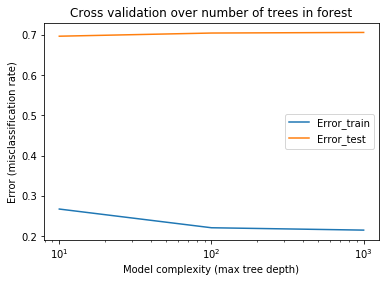

Lowest average error is 0.4603 at 1000.0 using 50.0 percent for testing
Lowest unweighted error is 0.4603 at 1000.0
Lowest test error is 0.6963 at 0
[[0.26720918 0.22078442 0.21491462]
 [0.69627851 0.70414833 0.70561558]]


In [79]:
plt.semilogx(estimators, error[0,:])
plt.semilogx(estimators, error[1,:])
plt.xlabel('Model complexity (max tree depth)')
plt.ylabel('Error (misclassification rate)')
plt.legend(['Error_train','Error_test']) 
plt.title('Cross validation over number of trees in forest')
plt.show()  


errorSum = test_proportion*error[1,:] + (1-test_proportion)*error[0,:] # mean error
error_equal = sum(error)
print('Lowest average error is {:.4f} at {} using {} percent for testing'.format(min(errorSum), estimators[np.argmin(errorSum)],test_proportion*100))
print('Lowest unweighted error is {:.4f} at {}'.format(min(error_equal)/2,estimators[np.argmin(error_equal)]))
print('Lowest test error is {:.4f} at {}'.format(min(error[1,:]),np.argmin(error[1,:])))

print(error)

### Random forest results

Does not seem to perform better than a single decision tree.

# Logistic regression

In [84]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_est_test = logreg.predict(X_test)
y_est_train = logreg.predict(X_train)

test_class_error = 1-np.mean(np.round(y_est_test,0) == y_test)
train_class_error = 1-np.mean(np.round(y_est_train,0) == y_train)

print('Test error: {:.4f}'.format(test_class_error))
print('Training error: {:.4f}'.format(train_class_error))

Test error: 0.6723
Training error: 0.6610


# K-Nearest Neighbors

In [85]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)


y_est_test = knn.predict(X_test)
y_est_train = knn.predict(X_train)

test_class_error = 1-np.mean(np.round(y_est_test,0) == y_test)
train_class_error = 1-np.mean(np.round(y_est_train,0) == y_train)

print('Test error: {:.4f}'.format(test_class_error))
print('Training error: {:.4f}'.format(train_class_error))

Test error: 0.6821
Training error: 0.4586


# Support Vector Machine

In [88]:
from sklearn.svm import SVC
svm = SVC()
svm.fit(X_train, y_train)

y_est_test = svm.predict(X_test)
y_est_train = svm.predict(X_train)

test_class_error = 1-np.mean(np.round(y_est_test,0) == y_test)
train_class_error = 1-np.mean(np.round(y_est_train,0) == y_train)

print('Test error: {:.4f}'.format(test_class_error))
print('Training error: {:.4f}'.format(train_class_error))

Test error: 0.6448
Training error: 0.3123


# Naive Bayes

In [89]:

from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)

y_est_test = gnb.predict(X_test)
y_est_train = gnb.predict(X_train)

test_class_error = 1-np.mean(np.round(y_est_test,0) == y_test)
train_class_error = 1-np.mean(np.round(y_est_train,0) == y_train)

print('Test error: {:.4f}'.format(test_class_error))
print('Training error: {:.4f}'.format(train_class_error))

Test error: 0.7031
Training error: 0.6885
